In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import netwulf as wulf
import random
from networkx.algorithms import community
from community import community_louvain
from tabulate import tabulate
import json
import jsonpickle
from networkx.readwrite import json_graph

### Part 2: Communities

#### Exercise 2: Zachary's karate club: In this exercise, we will work on Zarachy's karate club graph.

The dataset is available in NetworkX, by calling the function karate_club_graph

In [2]:
#creating the graph
G = nx.karate_club_graph()

1. Visualize the graph using netwulf. Set the color of each node based on the club split (the information is stored as a node attribute).

In [3]:
#prepare the dataset, label each node to store color information for the visualization
belonging = nx.get_node_attributes(G, 'club')

ColorArray =[]
partition_prep = [[],[]]

for i in belonging:
    if belonging[i] == "Mr. Hi":
        ColorArray.append("#606060FF")
        partition_prep[0].append(i)
    else:
        ColorArray.append("#D6ED17FF")
        partition_prep[1].append(i)


dictionaryColor = dict(zip(list(G.nodes), ColorArray))
nx.set_node_attributes(G, dictionaryColor,"color")

In [4]:
#create custom configuration for netwulf, so it is immediatelly nice after we run it
custom_config = {
    "zoom": 1.09320127948937,
    "node_charge": -100,
    "node_gravity": 0.02906058760349766,
    "link_distance": 50,
    "link_distance_variation": 0,
    "node_collision": False,
    "wiggle_nodes": False,
    "freeze_nodes": False,
    "node_fill_color": "#79aaa0",
    "node_stroke_color": "#555555",
    "node_label_color": "#000000",
    "node_size": 6.64244264770301,
    "node_stroke_width": 1.0171237334889143,
    "node_size_variation": 0.5,
    "display_node_labels": False,
    "scale_node_size_by_strength": False,
    "link_color": "#7c7c7c",
    "link_width": 3.9941371000922654,
    "link_alpha": 0.4026983428655228,
    "link_width_variation": 0.6,
    "display_singleton_nodes": True,
    "min_link_weight_percentile": 0,
    "max_link_weight_percentile": 1
}

In [ ]:
#visualizing using netwulf
wulf.visualize(G, config = custom_config, plot_in_cell_below=False)

![title](netwulf.png)

2. Write a function to compute the modularity of a graph partitioning (use equation 9.12 in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

In [12]:
#helper method to calculate degree of a graph
def get_total_degree(G):
    sum = 0
    for i in range(G.number_of_nodes()):
        sum += G.degree(list(G)[i])
    return sum

The modularity is calculated as: <br>
$Q = \sum_{c=1}^{n}
       \left[ \frac{L_c}{m} - \gamma\left( \frac{k_c}{2m} \right) ^2 \right]$
<br>where
- L_c is the number of links within community c
- m is the total number of connections in the graph
- k_c is the total degree of each community c
- $\gamma$ is the resolution parameter (in this case 1)

In [13]:
def Modularity(G,  p):
    mod = 0.0
    L = G.number_of_edges()
    for i in range(len(p)):
        tmp = G.subgraph(p[i])
        L_c = tmp.number_of_edges()
        k_c = get_total_degree(tmp)
        mod += ((L_c/L) - pow((k_c/(2*L)),2))
    return mod

3. Explain in your own words the concept of modularity.
<br>

Modularity helps to gain an idea about how well-partitioned a graph is to communities.
It compares the inner edges of each group with all of the edges.
It shows how well the communitie's nodes are connected to each other, as opposed to the whole network.

4. Compute the modularity of the Karate club split partitioning using the function you just wrote.

In [14]:
actualModularity = Modularity(G, partition_prep)
print("Modularity of the club split in Zachary's karate club: "+str(actualModularity))

Modularity of the club split in Zachary's karate club: 0.48931623931623935


5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from 0. To do so, we will implement the double edge swap algorithm.

In [16]:
#copying graph
G_copy = nx.Graph(G)

In [40]:
#implementing double edge swap based on the description of the task
def double_edge_swap(G):
    n = 0
    swapcount = 0
    degrees = get_total_degree(G)
    edge_list = list(G.edges)
    while swapcount < G.number_of_edges()+2: #number of edges+2 is just a choice of mine, it could be anything
        r1 = random.randint(0,len(edge_list)-1) #picking 2 random edges
        r2 = random.randint(0,len(edge_list)-1)
        uv = edge_list[r1]
        xy = edge_list[r2]
        if (uv[0] == xy[0]) or (uv[0] == xy[1]): #if the 2 edges suitable, swap them
            continue
        if (uv[1] == xy[0]) or (uv[1] == xy[1]):
            continue
        if (edge_list.__contains__((uv[0],xy[0])) == False) and (edge_list.__contains__((uv[1],xy[1])) == False):
            if (edge_list.__contains__((xy[0],uv[0])) == False) and (edge_list.__contains__((xy[1],uv[1])) == False):
                G.add_edge(uv[0],xy[0])
                G.add_edge(uv[1],xy[1])
                G.remove_edge(uv[0],uv[1])
                G.remove_edge(xy[0],xy[1])
                edge_list = list(G.edges)
                swapcount += 1
    #print(str(swapcount) + " swaps are done.")
    

6. Double check that your algorithm works well, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.

In [22]:
swapped = double_edge_swap(G_copy)

In [23]:
print("Degree of original graph: "+ str(get_total_degree(G_copy)))
print("Degree of swapped graph: "+ str(get_total_degree(swapped)))

Degree of original graph: 156
Degree of swapped graph: 156


7. Create 1000 randomized version of the Karate Club network using the double edge swap algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list

In [42]:
#creating 1000 swapped graphs
modularityList = []
for i in range(1000):
    G_copy = nx.Graph(G)
    double_edge_swap(G_copy)
    modularityList.append(Modularity(G_copy, partition_prep))

8. Compute the average and standard deviation of the modularity for the random network.

In [43]:
print("Average of the modularities: "+str(sum(modularityList) / len(modularityList)))

Average of the modularities: 0.3912472057856665


In [44]:
print("Standard deviation of the modularities: "+str(np.std(modularityList)))

Standard deviation of the modularities: 0.022432186499064224


9. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use axvline).

In [45]:
#helper for the chart
min(modularityList), max(modularityList)

(0.31771860618014464, 0.4478961209730441)

Text(0.455, 150, '  Original\nmodularity')

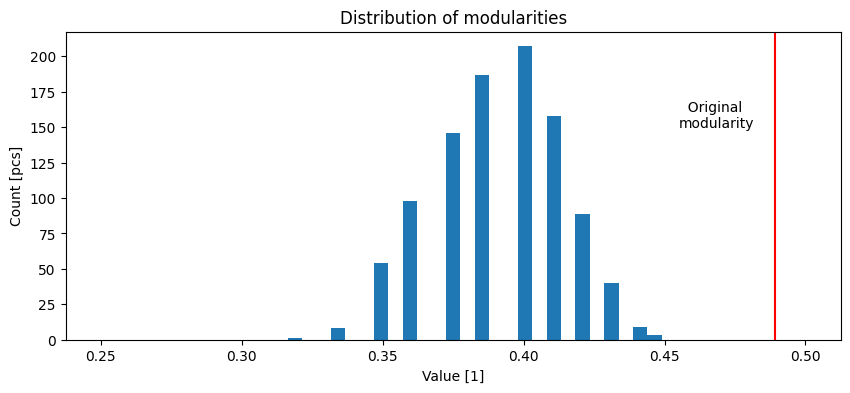

In [47]:
#create bins and histogram data
bins = np.linspace(0.25,0.5,50)
hist, edges = np.histogram(modularityList,bins=bins)
x = (edges[1:]+edges[:-1])/2
width = bins[1]-bins[0]

#create plot
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title("Distribution of modularities")
ax.set_xlabel("Value [1]")
ax.set_ylabel("Count [pcs]")
ax.bar(x,hist,width=width)
#plt.xlim([0.25,0.5])
ax.axvline(actualModularity, c='r')
plt.text(0.455,150,'  Original\nmodularity')

10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?

- As the club split's modularity is much higher than the average, it should be considered as a good partitioning.
- I think the randomization helped to contrast the original groups to randomly created ones.
- The nodes' degree is highly involved in the computing of modularity, so it must be preserved if we want to draw conclusions.

11. Use the Python Louvain-algorithm implementation to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

In [48]:
#finding communities
louvainPartition_tmp = community_louvain.best_partition(G)

In [49]:
#formatting to have similar datasets
louvainPartition = []
nogroups = 0
for i in range(len(louvainPartition_tmp)):
    if louvainPartition_tmp[i]>= nogroups:
        nogroups = louvainPartition_tmp[i]
for i in range(nogroups+1):
    louvainPartition.append([])
for i in range(len(louvainPartition_tmp)):
    louvainPartition[louvainPartition_tmp[i]].append(i)

In [50]:
louvainPartition

[[0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21],
 [4, 5, 6, 10, 16],
 [8, 9, 14, 15, 18, 20, 22, 26, 28, 29, 30, 32, 33],
 [23, 24, 25, 27, 31]]

In [51]:
partition_prep

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21],
 [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]

In [52]:
print("Modularity with the found communities: " + str(Modularity(G, louvainPartition)))
print("Modularity of the club split: " + str(actualModularity))

Modularity with the found communities: 0.5524326101249178
Modularity of the club split: 0.48931623931623935


The modularity is higher, which shows that the club split is not the most accurate division of the group.<br>
In fact this suggests, that we could split these 2 groups into even smaller communities, which will result in a higher modularity number.

12. Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix D with dimension (2 times A), where A is the number of communities found by Louvain. We set entry D(i,j) to be the number of nodes that community i has in common with group split j. The matrix D is what we call a confusion matrix. Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [53]:
#creating confusion matrix
data = [["","Louvain group 1", "Louvain group 2","Louvain group 3","Louvain group 4"],
        ["Club group 1", len(set(louvainPartition[0]).intersection(set(partition_prep[0]))),
        len(set(louvainPartition[0]).intersection(set(partition_prep[1]))),
        len(set(louvainPartition[1]).intersection(set(partition_prep[0]))),
        len(set(louvainPartition[1]).intersection(set(partition_prep[1])))],
        ["Club group 2", len(set(louvainPartition[2]).intersection(set(partition_prep[0]))),
        len(set(louvainPartition[2]).intersection(set(partition_prep[1]))),
        len(set(louvainPartition[3]).intersection(set(partition_prep[0]))),
        len(set(louvainPartition[3]).intersection(set(partition_prep[1])))]]

In [54]:
print(tabulate(data, tablefmt="fancy_grid"))

╒══════════════╤═════════════════╤═════════════════╤═════════════════╤═════════════════╕
│              │ Louvain group 1 │ Louvain group 2 │ Louvain group 3 │ Louvain group 4 │
├──────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┤
│ Club group 1 │ 11              │ 0               │ 5               │ 0               │
├──────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┤
│ Club group 2 │ 1               │ 12              │ 0               │ 5               │
╘══════════════╧═════════════════╧═════════════════╧═════════════════╧═════════════════╛


The takeaway here is that since almost all nodes of the Louvain groups are either from the club split 1 or 2 (only one exception to this), <br>
the Louvain groups represent a similar community division as the original, it just consits of 2 extra groups.<br>
Adding group 1-3 and 2-4 together would almost result in the same groups.

#### Exercise 3: Community detection on the network of Computational Social Scientists.

13. Consider the network you built in Week 4. <br>
Use the Python Louvain-algorithm implementation to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0?

In [55]:
# Load the JSON file
with open('graph.json') as f:
    data = json.load(f)

# Create a new NetworkX graph
G_CSS = nx.Graph()

# Add nodes to the graph
for node in data['nodes']:
    G_CSS.add_node(node['id'], name=node['name'], field=node['field'], median_cit_count=node['median_cit_count'], first_paper=node['first_paper'])

# Add edges to the graph
for edge in data['links']:
    G_CSS.add_edge(edge['source'], edge['target'], weight=edge['weight'])

In [56]:
louvainPartition_CSS = community_louvain.best_partition(G_CSS)

In [57]:
all_comms = max(louvainPartition_CSS.values())
print("Communities found: " + str(all_comms))

Communities found: 871


In [58]:
#convert dict to a more managable format for myself
louvainPartition = []
for i in range(all_comms + 1):
    louvainPartition.append([])
for node_id, group_id in louvainPartition_CSS.items():
    louvainPartition[group_id].append(node_id)

Showing a few examples of the sizes of communities:

In [59]:
for i in range(30):
    print(len(louvainPartition[i]), end =", ")

11, 1, 165, 1, 32, 165, 170, 160, 74, 116, 186, 1, 2, 1, 26, 66, 275, 2, 189, 62, 9, 67, 117, 78, 85, 99, 2, 1, 14, 51, 

In [60]:
#computing modularity
community_louvain.modularity(louvainPartition_CSS, G_CSS)

0.881642659683017

Yes, the modularity is fairly close to 1, that means the division is good. <br>Since this is the purpose of the algorithm (to create a division which represents groups), this was expected.

14. If you are curious, you can also try the Infomap algorithm. Go to [this page]. (https://mapequation.github.io/infomap/python/). It's harder to install, but a better community detection algorithm. You can read about it in advanced topics 9B.

- I couldn't make this work, the package is broken (all versions) for some reason.
- I would expect this algorithm to create a better division, which would result in a higher modularity.

15. Visualize the network, using netwulf (see Week 5). This time assign each node a different color based on their community. Describe the structure you observe. <br>
Make sure you save the assignment of authors to communities.

In [63]:
mydict = louvainPartition_CSS

In [81]:
ColorArray =[]

#generating a color for each community
for key in mydict:
    value = mydict[key]
    hexcode = str('#%03X%03X' % (value,value))
    ColorArray.append(hexcode)
    
dictionaryColor = dict(zip(list(G_CSS.nodes), ColorArray))
nx.set_node_attributes(G_CSS, dictionaryColor,"color")

In [ ]:
#visualizing using netwulf
wulf.visualize(G_CSS, plot_in_cell_below=False)

- The densely connected inner part is dominated by a few (approximately 7-8) groups, while there are a lot of single nodes towards the perimeter.
- I think it could help, if we filtered out the single nodes.

![title](css_vis.png)